In [2]:
import numpy as np
import math


In [3]:
import matplotlib.pyplot as plt

In [4]:
from pathlib import Path
import os

# root = Path(__file__).parent.parent  # top-level directory
root = Path(os.getcwd()).parent  # top-level directory

DATA_PATH = root / "data/"  # datasets and pretrained weights
TRAINING_PATH = root / "outputs/training/"  # training checkpoints
EVAL_PATH = root / "outputs/results/"  # evaluation results


In [5]:
def read_image(path: Path, grayscale: bool = False) -> np.ndarray:
    """Read an image from path as RGB or grayscale"""
    if not Path(path).exists():
        raise FileNotFoundError(f"No image at path {path}.")
    mode = cv2.IMREAD_GRAYSCALE if grayscale else cv2.IMREAD_COLOR
    image = cv2.imread(str(path), mode)
    if image is None:
        raise IOError(f"Could not read image at {path}.")
    if not grayscale:
        image = image[..., ::-1]
    return image


In [6]:
import torch
from torch import nn
import torch.nn.functional as F
import os
print(os.getcwd())
# from gluefactory.models.deeplsd_inference import DeepLSD
from gluefactory.models.lines.deeplsd import DeepLSD

/Users/soroush/LDocuments/University/MSc/Term 2/3dv/project/glue-factory


In [13]:
from gluefactory.utils.experiments import load_experiment
from gluefactory.models.extractors.jpldd.joint_point_line_extractor import JointPointLineDetectorDescriptor

In [8]:
import cv2

In [9]:
from torchvision.transforms import Resize

In [37]:
import flow_vis
def get_flow_vis(df, ang, line_neighborhood=5):
    norm = line_neighborhood + 1 - np.clip(df, 0, line_neighborhood)
    flow_uv = np.stack([norm * np.cos(ang), norm * np.sin(ang)], axis=-1)
    flow_img = flow_vis.flow_to_color(flow_uv, convert_to_bgr=False)
    return flow_img

In [10]:
def numpy_image_to_torch(image):
    """Normalize the image tensor and reorder the dimensions."""
    if image.ndim == 3:
        image = image.transpose((2, 0, 1))  # HxWxC to CxHxW
    elif image.ndim == 2:
        image = image[None]  # add channel axis
    else:
        raise ValueError(f"Not an image: {image.shape}")
    return torch.tensor(image / 255.0, dtype=torch.float)

In [11]:
name = '255027795_2652471757_o'
# name = '17450068_dc7884b082_o'
name = '562094050_5938f37ea5_o'

In [12]:
conf_lines = {
    "min_length": 25,
    "max_num_lines": None,
    "force_num_lines": False,
    "model_conf": {
        "detect_lines": True,
        "line_detection_params": {
            "merge": False,
            "grad_nfa": True,
            "filtering": "normal",
            "grad_thresh": 3.0,
        },
    }
}

size = (800,800)

conf_homography = {
    'translation': True,
    'rotation': True,
    'scaling': True,
    'perspective': True,
    'scaling_amplitude': 0.2,
    'perspective_amplitude_x': 0.2,
    'perspective_amplitude_y': 0.2,
    'patch_ratio': 0.85,
    'max_angle': 1.57,
    'allow_artifacts': True
}
resize_func = Resize(size)
image_path = f"../SOLD2/experiments/{name}.jpg"
img = cv2.resize(cv2.imread(image_path),size)
img_torch = numpy_image_to_torch(img)
img_torch = img_torch.unsqueeze(0)

img_torch.shape

torch.Size([1, 3, 800, 800])

In [15]:
jpldd_conf = {
    "name": "jpldd.joint_point_line_extractor",
    "model_name": "aliked-n16",
    "max_num_keypoints": 1000,  # setting for training, for eval: -1
    "pretrained": True,
    "timeit": True,  # override timeit: False from BaseModel
    "train_descriptors": {
        "do": False,  # if train is True, initialize ALIKED Light model form OTF Descriptor GT
        "device": None # device to house the lightweight ALIKED model
    }
}
jpldd_model = load_experiment("./experiments/weights/jpldd_09.tar", jpldd_conf)
#jpldd_model = JointPointLineDetectorDescriptor({})

[05/24/2024 17:25:42 gluefactory.utils.experiments INFO] Loading checkpoint jpldd_09.tar
Load pretrained weights for aliked parts...
Downloading: "https://github.com/Shiaoming/ALIKED/raw/main/models/aliked-n16.pth" to /Users/soroush/.cache/torch/hub/checkpoints/aliked-n16.pth
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.61M/2.61M [00:00<00:00, 14.3MB/s]
Load ALiked Lightweight model for descriptor training...
Downloading: "https://github.com/Shiaoming/ALIKED/raw/main/models/aliked-n32.pth" to /Users/soroush/.cache/torch/hub/checkpoints/aliked-n32.pth
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3.76M/3.76M [00:00<00:00, 18.2MB/s]
[05/24/2024 17:25:45 gluefactory.utils.exper

In [22]:
%%time

with torch.no_grad():
    output_jpldd = jpldd_model({"image": img_torch})
output_jpldd.keys()

CPU times: user 13.2 s, sys: 3.15 s, total: 16.4 s
Wall time: 2.14 s


dict_keys(['keypoint_and_junction_score_map', 'line_anglefield', 'line_distancefield', 'keypoints_raw', 'keypoints', 'keypoint_scores', 'descriptors'])

In [21]:
%%time

with torch.no_grad():
    # output_superpoint = superpoint_model({"image": img_torch})
    output_jpldd = jpldd_model({"image": img_torch})
    # output_deeplsd = deeplsd_model.forward_ha({"image": img_torch})
# distance_field_jpldd = torch.exp(-output_jpldd["deeplsd_line_distancefield"][0])*5
# distance_field_jpldd = output_jpldd["deeplsd_line_distancefield"][0]
# angle_field_jpldd = output_jpldd["deeplsd_line_anglefield"][0]*torch.pi
output_jpldd.keys()

dict_keys(['keypoint_and_junction_score_map', 'line_anglefield', 'line_distancefield', 'keypoints_raw', 'keypoints', 'keypoint_scores', 'descriptors'])

In [32]:
jpldd_kpjhm = output_jpldd['keypoint_and_junction_score_map'][0]
jpldd_af = output_jpldd['line_anglefield'][0]
jpldd_df = output_jpldd['line_distancefield'][0]
jpldd_kpr = output_jpldd['keypoints_raw'][0]
jpldd_kp = output_jpldd['keypoints'][0]
jpldd_kpsc = output_jpldd['keypoint_scores'][0]
jpldd_desc = output_jpldd['descriptors'][0]

jpldd_kpjhm.shape, jpldd_af.shape, jpldd_df.shape, jpldd_kpr.shape, jpldd_kp.shape, jpldd_kpsc.shape, jpldd_desc.shape

(torch.Size([800, 800]),
 torch.Size([800, 800]),
 torch.Size([800, 800]),
 torch.Size([1000, 2]),
 torch.Size([1000, 2]),
 torch.Size([1000]),
 torch.Size([1000, 128]))

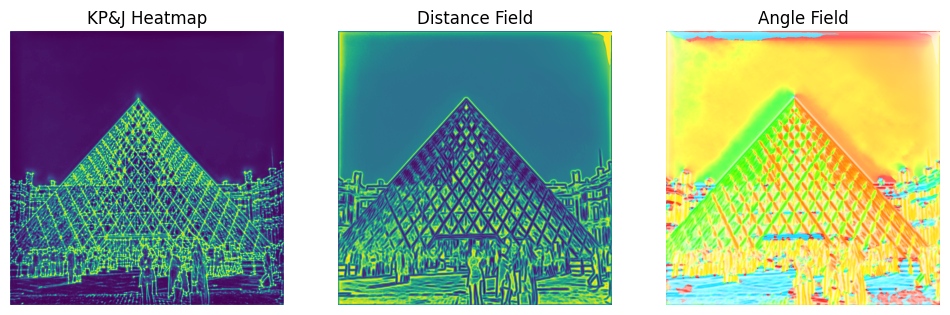

In [50]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].axis('off')
ax[0].set_title('KP&J Heatmap')
ax[0].imshow(jpldd_kpjhm)

ax[1].axis('off')
ax[1].set_title('Distance Field')
ax[1].imshow(jpldd_df)

ax[2].axis('off')
ax[2].set_title('Angle Field')
ax[2].imshow(get_flow_vis(jpldd_df, jpldd_af))
plt.show()

In [109]:
from kornia.feature import SOLD2 as s2

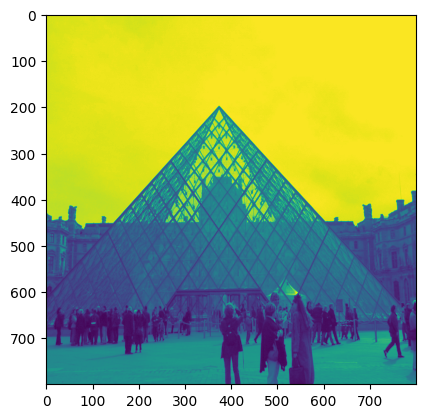

In [110]:
scale = img_torch.new_tensor([0.299, 0.587, 0.114]).view(1, 3, 1, 1)
gs_image = (img_torch * scale).sum(1, keepdim=True)
plt.imshow(gs_image.squeeze().numpy())

In [111]:
#homography =  sample_homography(img,conf_homography,size)
#warped_img = homography["image"]
#warped_img = numpy_image_to_torch(warped_img)

#warped_img = warped_img.unsqueeze(0)


# model2 = DeepLSD(conf_lines)
model2 = s2()


model2.eval()
with torch.no_grad():
    # pred2 = model2({"image": warped_img})
    # pred2 = model2.forward_ha({"image": img_torch})
    pred1 = model2(gs_image)
   
    # pred2 = {k: v[0].cpu().numpy() for k, v in pred2.items()}
    lines = pred1
    # line_scores = pred2["line_scores"]
    # valid_lines = pred2["valid_lines"]
    
# Show lines
#print(lines[0][0][0])

# distance_field, angle_field, _ = torch_homography_adaptation(img_torch,model2,num_H=10,aggregation="mean")

In [112]:
pred1.keys()

dict_keys(['junction_heatmap', 'line_heatmap', 'dense_desc', 'line_segments'])

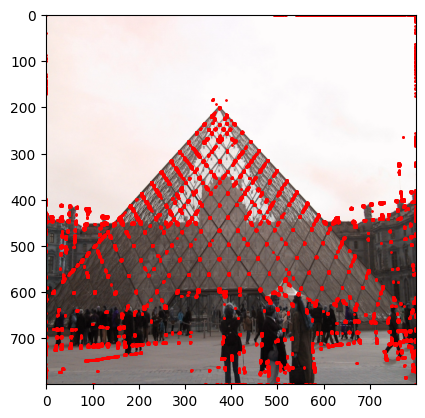

In [113]:
jhm = np.array(pred1['junction_heatmap'].squeeze())
jhm[jhm < jhm.mean()] = 0
jp = jhm.nonzero()

plt.imshow(img)
# plt.imshow(jhm, alpha = 0.5)
# plt.imshow(jhm / jhm.max())
plt.scatter(*jp[::-1], c='r', s=1)
plt.show()

(1, 421, 2, 2)


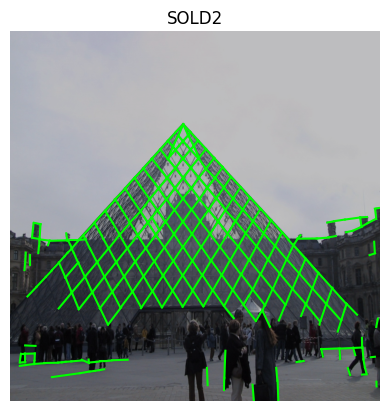

In [123]:

lines = np.array(pred1['line_segments'])
print(lines.shape)
# lines[0] = warp_lines(lines[0],homography)
# warped_img = cv2.cvtColor(warped_img[0].permute(1,2,0).numpy(),cv2.COLOR_BGR2RGB)
# plt.imshow(warped_img)
# plt.imshow(img)
plt.title('SOLD2')
plt.axis('off')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(np.zeros_like(img), alpha=0.25)
for line in lines[0]:
   plt.plot(line[:, 1], line[:, 0], c='lime')
plt.show()

In [115]:
#homography =  sample_homography(img,conf_homography,size)
#warped_img = homography["image"]
#warped_img = numpy_image_to_torch(warped_img)

#warped_img = warped_img.unsqueeze(0)


model2 = DeepLSD(conf_lines)
# model2 = s2()


model2.eval()
with torch.no_grad():
    # pred2 = model2({"image": warped_img})
    pred2 = model2.forward_ha({"image": img_torch})
    # pred2 = model2(gs_image)
   
    # pred2 = {k: v[0].cpu().numpy() for k, v in pred2.items()}
    lines = pred2
    # line_scores = pred2["line_scores"]
    # valid_lines = pred2["valid_lines"]
    
# Show lines
#print(lines[0][0][0])

# distance_field, angle_field, _ = torch_homography_adaptation(img_torch,model2,num_H=10,aggregation="mean")

In [116]:
pred2.keys()

dict_keys(['df_norm', 'df', 'line_level', 'lines'])

In [117]:
pred2

{'df_norm': tensor([[[0.7248, 0.6858, 0.5856,  ..., 0.7459, 0.7819, 0.7854],
          [0.8129, 0.6842, 0.4740,  ..., 0.7954, 0.8536, 0.7359],
          [0.8294, 0.6961, 0.5910,  ..., 0.6559, 0.6473, 0.5658],
          ...,
          [0.4569, 0.4609, 0.4970,  ..., 1.6311, 1.5590, 1.5371],
          [0.5012, 0.5162, 0.5808,  ..., 1.3065, 1.3908, 1.4433],
          [0.6062, 0.5524, 0.5370,  ..., 1.0701, 1.1903, 1.1676]]]),
 'df': tensor([[[2.4222, 2.5185, 2.7839,  ..., 2.3716, 2.2878, 2.2797],
          [2.2179, 2.5224, 3.1125,  ..., 2.2569, 2.1295, 2.3953],
          [2.1815, 2.4926, 2.7689,  ..., 2.5948, 2.6174, 2.8394],
          ...,
          [3.1662, 3.1537, 3.0417,  ..., 0.9786, 1.0517, 1.0750],
          [3.0291, 2.9840, 2.7974,  ..., 1.3539, 1.2443, 1.1807],
          [2.7270, 2.8779, 2.9226,  ..., 1.7149, 1.5207, 1.5556]]]),
 'line_level': tensor([[[2.4758, 2.4438, 2.5575,  ..., 0.5937, 0.7610, 0.7533],
          [2.4606, 2.5220, 2.6103,  ..., 0.7712, 0.9660, 1.0000],
         

(1, 796, 2, 2)


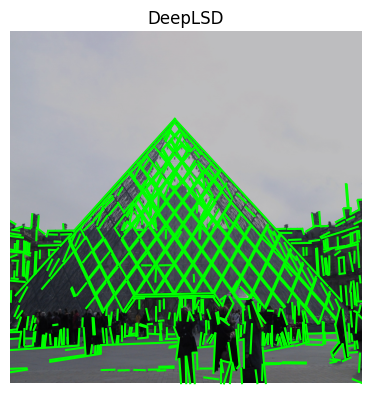

In [121]:

lines = np.array(pred2['lines'])
print(lines.shape)
# lines[0] = warp_lines(lines[0],homography)
# warped_img = cv2.cvtColor(warped_img[0].permute(1,2,0).numpy(),cv2.COLOR_BGR2RGB)
# plt.imshow(warped_img)
# plt.imshow(img)
plt.axis('off')
plt.title('DeepLSD')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(np.zeros_like(img), alpha=0.25)
for line in lines[0]:
   plt.plot(line[:, 0], line[:, 1], c='lime')
plt.show()

NameError: name 'distance_field' is not defined

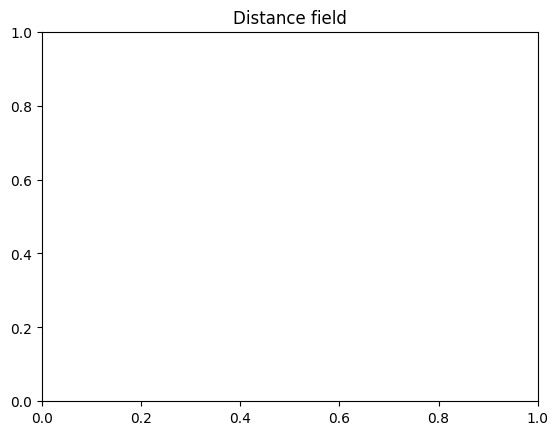

In [119]:
plt.title("Distance field")
plt.imshow(distance_field)

In [15]:
import h5py
path = "ground_truth/DeepLSD/images/0033/488168399_daed32f880_o.hdf5"
with h5py.File(path, "r") as hdf_file:
        distance_field = np.array(hdf_file["deeplsd_distance_field"])
        angle_field = np.array(hdf_file["deeplsd_angle_field"])
        

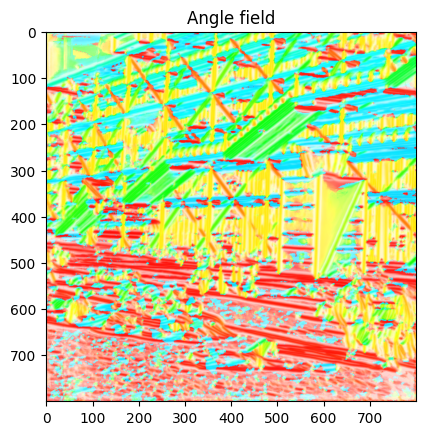

In [16]:
import matplotlib.pyplot as plt
plt.title("Angle field")
#plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

plt.imshow(get_flow_vis(distance_field,angle_field))

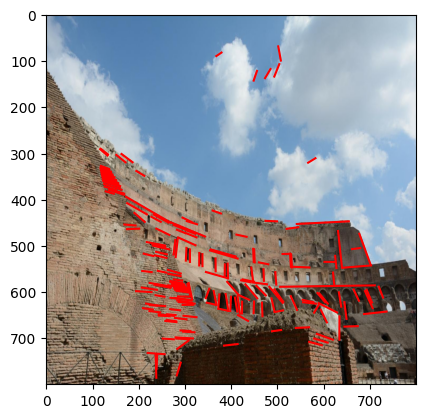

In [29]:
from gluefactory.geometry.homography import warp_points

#h_inv = np.linalg.inv(homography["H_"])
warped_lines = warp_points(lines[0].reshape(-1, 2), homography["H_"]).reshape(-1, 2, 2)

#lines[0] = warp_lines(lines[0],h_inv)
#warped_back_img = cv2.warpPerspective(warped_img, h_inv, size,
#                                         borderMode=cv2.BORDER_REPLICATE)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
for line in warped_lines:
    plt.plot(line[:, 0], line[:, 1], c='r')
plt.show()

In [1]:
from omegaconf import OmegaConf
from gluefactory.datasets import get_dataset

def get_dataset_and_loader(num_workers):  # folder where dataset images are placed
    config = {
        'name': 'minidepth',  # name of dataset class in gluefactory > datasets
        'grayscale': True,  # commented out things -> dataset must also have these keys but has not
        'preprocessing': {
            'resize': [800, 800]
        },
        'train_batch_size': 1,  # prefix must match split mode
        'num_workers': num_workers,
        'split': 'train'  # if implemented by dataset class gives different splits
    }
    omega_conf = OmegaConf.create(config)
    dataset = get_dataset(omega_conf.name)(omega_conf)
    loader = dataset.get_data_loader(omega_conf.get('split', 'train'))
    return loader

In [2]:
#from gluefactory.ground_truth_generation.generate_gt_deeplsd import generate_ground_truth_with_homography_adaptation
from gluefactory.models.lines.deeplsd import DeepLSD
from gluefactory.ground_truth_generation.deeplsd_gt_multiple_files import process_image
from pathlib import Path
# Empty conf = use default conf
data_dir = Path("ground_truth")
deeplsd_dir = data_dir / "DeepLSD"
net = DeepLSD({})
dataloader = get_dataset_and_loader(1)
#img = img_data["image"]
for image in dataloader:
    print(image["image"].shape)
    process_image(image,10,deeplsd_dir)
    print("It worked")
    break

[04/28/2024 20:48:04 gluefactory.datasets.base_dataset INFO] Creating dataset MiniDepthDataset
[04/28/2024 20:48:05 gluefactory.datasets.minidepth INFO] NUMBER OF IMAGES: 9426


torch.Size([1, 1, 800, 800])
It worked


In [ ]:
def get_valid_lines(
    lines, 
    df,
    af,
    n_samples=10, 
    df_thresh=5, 
    inlier_thresh=0.7,
    r_ratio=0.1, 
    a_diff_thresh=np.pi/20, 
    refinement_a_diff_thresh=np.pi/60,
    a_std_thresh=np.pi/30,
    r_radius=5,
    b_diff_thresh=5,
    merge=False,
    check_sample=False,
):
    '''
    lines: (N, 2, 2) -> each of the N elements: [[x1, x2], [y1, y2]]
    '''
    
    validity = (lines[:, 0, 0] != lines[:, 0, 1]) & (lines[:, 1, 0] != lines[:, 1, 1])
    lines = lines[validity]

    offsets = torch.linspace(0, 1, n_samples).view(1, 1, -1)

    xs = lines[:, 0, :1] + (lines[:, 0, 1:] - lines[:, 0, :1]) * offsets
    ys = lines[:, 1, :1] + (lines[:, 1, 1:] - lines[:, 1, :1]) * offsets

    xint = np.linspace(np.maximum(xs.T-r_radius, 0), np.minimum(xs.T+r_radius, df.shape[0] - 1), 2 * r_radius + 1).T.astype(int)
    yint = np.linspace(np.maximum(ys.T-r_radius, 0), np.minimum(ys.T+r_radius, df.shape[1] - 1), 2 * r_radius + 1).T.astype(int)

    point_indices = df[xint, yint].argmin(axis=-1)
    bs, rows, cols = np.indices(point_indices.shape)

    valid_xs = xint[rows, cols, point_indices]
    valid_ys = yint[rows, cols, point_indices]
    
    xs, ys = valid_xs, valid_ys
    
    points = df[xs, ys]
    angles = af[xs, ys]

    slope = (lines[:, 0, 1] - lines[:, 0, 0]) / (lines[:, 1, 1] - lines[:, 1, 0] + 1e-10)
    direction = np.mod(np.arctan(slope), np.pi)

    inlier_indices = points < df_thresh
    inlier_ratio = (inlier_indices).sum(axis=-1) / xs.shape[-1]
    
    rows, cols = np.indices(inlier_indices.shape)
    valid_angles = angles
    
    crit1 = points.mean(axis=-1) < df_thresh
    crit2 = valid_angles.std(axis=-1) < a_std_thresh
    crit3 = inlier_ratio > inlier_thresh
    crit4 = np.mod(np.abs(valid_angles.mean(axis=-1) - direction), np.pi) < a_diff_thresh

    validity = crit1 & crit2 & crit3 & crit4
    lines = lines[validity]

    # filter out the redundant lines
    filter_redundant_lines = False
    if filter_redundant_lines:
        xs = xs[validity]
        ys = ys[validity]
        
        slope = (lines[:, 0, 1] - lines[:, 0, 0]) / (lines[:, 1, 1] - lines[:, 1, 0] + 1e-10)
        direction = np.mod(np.arctan(slope), np.pi)
        b = ys[:, 0] - direction * xs[:, 0]
        redundant_b = np.repeat(b[..., np.newaxis], b.shape[0], axis=1)
        redundant_d = np.repeat(direction[..., np.newaxis], direction.shape[0], axis=1)
    
        redundancy_map = (
            np.triu(np.abs(b[..., np.newaxis] - b) < b_diff_thresh).astype(int) *
            np.triu(np.abs(direction[..., np.newaxis] - direction) < refinement_a_diff_thresh).astype(int)
        )
        redundancy_map = redundancy_map - np.eye(len(redundancy_map))
        redundant_lines = redundancy_map.nonzero()
    
        sq_lengths = (lines[:, 0, 1] - lines[:, 0, 0])**2 + (lines[:, 1, 1] - lines[:, 1, 0])**2
    
        # redundant_lines[0][sq_lengths[redundant_lines[0]] < sq_lengths[redundant_lines[1]]] = redundant_lines[1]
        
        # return redundant_lines
    
    if merge:
        lines = merge_lines(lines, thresh=4,
                            overlap_thresh=0).astype(np.float32)
        a, b = lines[:, 1].copy(), lines[:, 0].copy()
        lines[:, 0], lines[:, 1] = a, b

    if check_sample:
        print("points.mean()", points[check_sample].mean())
        print("direction", direction[check_sample])
        print("inlier_ratio", inlier_ratio[check_sample])
        print("angles.std()", angles[check_sample].std())
        print("angles.mean()", angles[check_sample].mean())
        print(crit1[check_sample], crit2[check_sample], crit3[check_sample], crit4[check_sample])
        plt.imshow(get_flow_vis(df, af))
        plt.imshow(df, alpha=0.3)

        x1 = xs[check_sample][0]
        y1 = ys[check_sample][0]
        ny = y1 + np.cos(direction[check_sample]) * 100
        nx = x1 + np.sin(direction[check_sample]) * 100
        plt.plot([y1, ny], [x1, nx], c='cyan')

        for x, y, a in zip(xs[check_sample], ys[check_sample], angles[check_sample]):
            ny = y + np.cos(a) * 15
            nx = x + np.sin(a) * 15
            plt.plot([y, ny], [x, nx], c='red', linewidth=0.75)
        
        plt.scatter(ys[check_sample], xs[check_sample], c='r', s=5)
        plt.scatter(valid_ys[check_sample], valid_xs[check_sample], c='lime', s=5)
        
        plt.scatter(*junctions.T.numpy()[::-1], c='b', s=0.5)
        
        plt.show()

    return lines

get_valid_lines(lines[:5000], jpldd_df, jpldd_af, check_sample=3700)